# Notebook 07 — Full System Integration
## Kenya Career & Skills Intelligence System — End-to-End Pipeline

This is the **final integration notebook**. It assembles all components from Notebooks 03–06 into a single, production-ready API function.

### Full Pipeline Architecture

```
User Input (any type)
       │
       ▼
┌─────────────────────────────────────────────────────────────┐
│  STAGE 1: Career Recommendation Engine (Notebook 03)        │
│  • Profile builder + Sentence Transformer encoding          │
│  • NearestNeighbors retrieval (top-50 candidates)           │
│  • GBM ranker → top-5 career recommendations               │
└─────────────────────┬───────────────────────────────────────┘
                      │  Top-5 careers
                      ▼
┌─────────────────────────────────────────────────────────────┐
│  STAGE 2: AI Risk Scoring Engine (Notebook 05)              │
│  • Blended BLS + skill-based risk score                     │
│  • Risk category (Low / Medium / High / Very High)          │
│  • Future-proof score                                       │
│  • Human-readable risk explanation + mitigation advice      │
└─────────────────────┬───────────────────────────────────────┘
                      │  Enriched career cards
                      ▼
┌─────────────────────────────────────────────────────────────┐
│  STAGE 3: Skills Gap Engine (Notebook 04)                   │
│  • User skill vector from free-text + education context     │
│  • Semantic skill mapping to O*NET dimensions               │
│  • Per-career gap analysis (critical / moderate / strong)   │
│  • Transferable skills detection                            │
└─────────────────────┬───────────────────────────────────────┘
                      │  Gap reports per career
                      ▼
┌─────────────────────────────────────────────────────────────┐
│  STAGE 4: Course Recommender (Notebook 06)                  │
│  • Gap-driven course search (per skill, per stage)          │
│  • Learning path sequencer (Foundation → Advanced)          │
│  • Platform diversity (Coursera + edX + Udemy)              │
└─────────────────────┬───────────────────────────────────────┘
                      │
                      ▼
         Complete System Output (JSON/DataFrame)
         • Top-5 career cards with scores
         • Per-career skills gap reports
         • Per-career learning paths
         • Dashboard data (sector risk, demand chart)
         • Transferable skills summary
```

### Outputs
- `career_system_v1.pkl` — full integrated system object
- `07_integration_summary.json` — pipeline evaluation summary

## 1.0 — Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
import joblib
import json
import time
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')

PROCESSED_DIR  = Path('DATA/processed')
MODEL_DIR      = Path('models')
ARTIFACTS_DIR  = Path('artifacts')
FIGURES_DIR    = Path('figures')

for d in [PROCESSED_DIR, MODEL_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Directories ready')

Directories ready


## 2.0 — Load All Model Artifacts

Load every component saved by Notebooks 02–06.

In [2]:
print('Loading master data...')

# ── Master occupation profiles (updated through Notebook 05) ──────────────────
master = pd.read_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet')
print(f'  Master profiles : {master.shape}')

# ── Course catalogue ──────────────────────────────────────────────────────────
courses = pd.read_parquet(PROCESSED_DIR / 'unified_courses.parquet')
print(f'  Course catalogue: {courses.shape}')

# ── Risk profiles (from Notebook 05) ─────────────────────────────────────────
try:
    risk_profiles_df = pd.read_parquet(PROCESSED_DIR / 'career_risk_profiles.parquet')
    print(f'  Risk profiles   : {risk_profiles_df.shape}')
except FileNotFoundError:
    risk_profiles_df = None
    print('  Risk profiles   : not found (run Notebook 05 first)')

# ── Sector risk summary ───────────────────────────────────────────────────────
try:
    sector_risk = pd.read_parquet(PROCESSED_DIR / 'sector_risk_summary.parquet')
    print(f'  Sector risk     : {sector_risk.shape}')
except FileNotFoundError:
    sector_risk = None
    print('  Sector risk     : not found (run Notebook 05 first)')

print()


Loading master data...
  Master profiles : (894, 58)
  Course catalogue: (8050, 14)
  Risk profiles   : (894, 10)
  Sector risk     : (12, 6)



In [3]:
# ── Sentence Transformer ──────────────────────────────────────────────────────
try:
    from sentence_transformers import SentenceTransformer
    _st_model        = SentenceTransformer('all-MiniLM-L6-v2')
    SEMANTIC_AVAILABLE = True
    print('  Sentence Transformer   : loaded')
except ImportError:
    SEMANTIC_AVAILABLE = False
    print('  Sentence Transformer   : NOT available (using TF-IDF fallback)')

# ── Career recommendation model artifacts (Notebook 03) ──────────────────────
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

retriever = joblib.load(MODEL_DIR / 'career_retriever.pkl')
ranker    = joblib.load(MODEL_DIR / 'career_ranker_gbm.pkl')
scaler    = joblib.load(MODEL_DIR / 'skill_scaler.pkl')
print('  Career retriever + ranker  : loaded')

# ── JSON config artifacts ─────────────────────────────────────────────────────
with open(ARTIFACTS_DIR / 'user_type_job_zones.json') as f:
    USER_TYPE_JOB_ZONES = json.load(f)

with open(ARTIFACTS_DIR / 'career_goal_boosts.json') as f:
    CAREER_GOAL_BOOSTS = json.load(f)

with open(ARTIFACTS_DIR / 'soc_family_map.json') as f:
    SOC_FAMILY_MAP = json.load(f)

with open(ARTIFACTS_DIR / 'skill_synonym_map.json') as f:
    SKILL_SYNONYM_MAP = json.load(f)

with open(ARTIFACTS_DIR / 'cbc_subject_skills.json') as f:
    CBC_SUBJECT_SKILLS = json.load(f)

with open(ARTIFACTS_DIR / 'kcse_subject_skills.json') as f:
    KCSE_SUBJECT_SKILLS = json.load(f)

print('  Config artifacts           : loaded')

# ── Course recommender (Notebook 06) ─────────────────────────────────────────
course_rec     = joblib.load(MODEL_DIR / 'course_recommender_v2.pkl')
COURSE_TFIDF   = course_rec['tfidf_vectorizer']
COURSE_MATRIX  = course_rec['course_matrix']
EDUCATION_COURSE_LEVELS = course_rec['education_level_map']
print('  Course recommender         : loaded')

# ── Skills gap engine (Notebook 04) ──────────────────────────────────────────
gap_engine  = joblib.load(MODEL_DIR / 'skills_gap_engine.pkl')
SKILL_COLS  = gap_engine['skill_cols']
CANONICAL_SKILLS = gap_engine['canonical_skills']
print('  Skills gap engine          : loaded')

# ── Risk engine config (Notebook 05) ─────────────────────────────────────────
risk_engine    = joblib.load(MODEL_DIR / 'ai_risk_engine.pkl')
RISK_THRESHOLDS  = risk_engine['risk_thresholds']
RISK_COLORS      = risk_engine['risk_colors']
RISK_EXPLANATIONS= risk_engine['risk_explanations']
print('  Risk engine                : loaded')

# ── Skill dim vectors for semantic skill matching ─────────────────────────────
try:
    SKILL_DIM_VECS = joblib.load(MODEL_DIR / 'skill_dim_vectors.pkl')
    print('  Skill dimension vectors    : loaded')
except FileNotFoundError:
    SKILL_DIM_VECS = None
    print('  Skill dimension vectors    : not found (run Notebook 04 first)')

print()
print('All artifacts loaded successfully')

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Sentence Transformer   : loaded
  Career retriever + ranker  : loaded
  Config artifacts           : loaded
  Course recommender         : loaded
  Skills gap engine          : loaded
  Risk engine                : loaded
  Skill dimension vectors    : loaded

All artifacts loaded successfully


## 3.0 — Integrate All Component Functions

Import all functions from previous notebooks (in production, these would be imported from a module).
Here we redefine the orchestration functions that call each component.

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# COMPONENT FUNCTIONS — copied from component notebooks for standalone use
# In production: from src.career_system import recommend_careers, analyse_skills_gap, ...
# ─────────────────────────────────────────────────────────────────────────────

# ── Helpers ───────────────────────────────────────────────────────────────────
def normalise_skill(skill_text: str) -> str:
    skill = skill_text.lower().strip()
    return SKILL_SYNONYM_MAP.get(skill, skill)


def categorise_risk(score: float) -> str:
    for label, (lo, hi) in RISK_THRESHOLDS.items():
        if lo <= score < hi:
            return label
    return 'Very High'


def _estimate_hours(courses_df: pd.DataFrame) -> float:
    if 'Duration (hrs)' in courses_df.columns:
        hrs = pd.to_numeric(courses_df['Duration (hrs)'], errors='coerce').fillna(20)
        return float(hrs.sum())
    return len(courses_df) * 20

print('Helper functions defined')

Helper functions defined


In [5]:
# ── User skill parser (from Notebook 04) ─────────────────────────────────────
def parse_user_skills(raw_input: dict) -> dict:
    user_skills_raw = raw_input.get('skills', '')
    soft_skills_raw = raw_input.get('soft_skills', '')
    user_type       = raw_input.get('user_type', 'graduate').lower()

    explicit_skills  = [normalise_skill(s) for s in user_skills_raw.split(',') if s.strip()]
    explicit_skills += [normalise_skill(s) for s in soft_skills_raw.split(',') if s.strip()]

    if user_type == 'cbc':
        pathway  = raw_input.get('pathway', '')
        explicit_skills += [normalise_skill(s) for s in CBC_SUBJECT_SKILLS.get(pathway, [])]
    elif user_type == '8-4-4':
        subjects = raw_input.get('subject_combination', '').split(',')
        for subj in subjects:
            explicit_skills += [normalise_skill(s) for s in KCSE_SUBJECT_SKILLS.get(subj.strip(), [])]

    user_dim_scores = {col: 0.0 for col in SKILL_COLS}

    if SEMANTIC_AVAILABLE and SKILL_DIM_VECS is not None and explicit_skills:
        user_vecs  = _st_model.encode(explicit_skills, show_progress_bar=False)
        sim_matrix = cosine_similarity(user_vecs, SKILL_DIM_VECS)
        for skill_idx in range(len(explicit_skills)):
            sims = sim_matrix[skill_idx]
            top3 = np.argsort(sims)[::-1][:3]
            for rank, dim_idx in enumerate(top3):
                col    = SKILL_COLS[dim_idx]
                score  = float(sims[dim_idx])
                weight = 1.0 if rank == 0 else (0.6 if rank == 1 else 0.3)
                user_dim_scores[col] = min(7.0, user_dim_scores[col] + score * weight * 7.0)
    else:
        for skill in explicit_skills:
            for col, desc in CANONICAL_SKILLS.items():
                if skill in desc or any(word in desc for word in skill.split()):
                    user_dim_scores[col] = min(7.0, user_dim_scores.get(col, 0.0) + 2.5)

    return user_dim_scores


print('User skill parser ready')

User skill parser ready


In [6]:
# ── Skills gap analyser (from Notebook 04) ───────────────────────────────────
def analyse_skills_gap(user_skill_scores: dict, occupation_row: pd.Series,
                       top_n_gaps: int = 8, top_n_strong: int = 5) -> dict:
    occ_name      = occupation_row.get('occupation', str(occupation_row.name))
    imp_total     = sum(float(occupation_row.get(c, 0)) for c in SKILL_COLS) or 1.0
    importance    = {col: float(occupation_row.get(col, 0)) / imp_total for col in SKILL_COLS}

    gap_details   = []
    strong_skills = []
    matched_w     = 0.0
    total_w       = 0.0

    for col in SKILL_COLS:
        required = float(occupation_row.get(col, 0))
        user     = float(user_skill_scores.get(col, 0))
        imp      = float(importance.get(col, 0))
        raw_gap  = max(0, required - user)
        surplus  = max(0, user - required)

        if required > 0:
            match_frac = min(1.0, user / required) if required > 0 else 1.0
            matched_w += imp * match_frac
            total_w   += imp

        label = col.replace('_', ' ').title()

        if required > 0.5 and raw_gap > 1.5:
            severity = 'Critical' if raw_gap > 3.0 else 'Moderate'
            gap_details.append({'Skill': label, 'Required': round(required, 1),
                                 'User Score': round(user, 1), 'Gap': round(raw_gap, 1),
                                 'Severity': severity, 'Importance': round(imp * 100, 1),
                                 'Priority': round(imp * raw_gap, 4)})
        elif user >= required * 0.8 and required > 0.5:
            strong_skills.append({'Skill': label, 'Required': round(required, 1),
                                   'User Score': round(user, 1), 'Surplus': round(surplus, 1)})

    alignment_pct  = round((matched_w / total_w) * 100, 1) if total_w > 0 else 0.0
    gap_details    = sorted(gap_details, key=lambda x: x['Priority'], reverse=True)[:top_n_gaps]
    strong_skills  = sorted(strong_skills, key=lambda x: x['User Score'], reverse=True)[:top_n_strong]

    for i, g in enumerate(gap_details, 1):
        g['Priority Order'] = i

    return {
        'occupation'   : occ_name,
        'alignment_pct': alignment_pct,
        'gap_count'    : len(gap_details),
        'critical_gaps': [g for g in gap_details if g['Severity'] == 'Critical'],
        'moderate_gaps': [g for g in gap_details if g['Severity'] == 'Moderate'],
        'strong_skills': strong_skills,
        'all_gaps'     : gap_details,
        'summary'      : (
            f"You are {alignment_pct}% aligned with {occ_name}. "
            f"{len([g for g in gap_details if g['Severity']=='Critical'])} critical and "
            f"{len([g for g in gap_details if g['Severity']=='Moderate'])} moderate gaps."
        ),
    }


print('Skills gap analyser ready')

Skills gap analyser ready


In [7]:
# ── Course search (from Notebook 06) ─────────────────────────────────────────
def search_courses_for_skill(skill_name: str, top_k: int = 3,
                             level_filter: str | None = None, min_quality: float = 0.3) -> pd.DataFrame:
    query     = skill_name.lower().replace('_', ' ')
    query_vec = COURSE_TFIDF.transform([query])
    sims      = cosine_similarity(query_vec, COURSE_MATRIX)[0]

    candidate_mask = courses['quality_score'].fillna(0) >= min_quality \
                     if 'quality_score' in courses.columns else np.ones(len(courses), dtype=bool)
    if level_filter:
        std_level = 'Foundation'
        if 'std_level' in courses.columns:
            candidate_mask = candidate_mask & (courses['std_level'] == level_filter)

    masked_sims = sims * candidate_mask.astype(float)
    top_idx     = np.argsort(masked_sims)[::-1][:top_k * 3]
    top_idx     = [i for i in top_idx if masked_sims[i] > 0.01][:top_k]

    results = []
    for idx in top_idx:
        row = courses.iloc[idx]
        results.append({
            'Course Title'   : row.get('course_title', 'Unknown'),
            'Platform'       : row.get('platform', 'Unknown'),
            'Level'          : row.get('std_level', 'Unknown') if 'std_level' in courses.columns else 'N/A',
            'Skills Covered' : str(row.get('skills_covered', ''))[:80],
            'Quality Score'  : round(float(row.get('quality_score', 0)), 2),
            'Duration (hrs)' : row.get('duration_hours', 'N/A'),
            'Is Free'        : row.get('is_free', False),
            'URL'            : row.get('url', ''),
            'Skill Match %'  : round(float(masked_sims[idx]) * 100, 1),
            'Skill Gap'      : skill_name.replace('_', ' ').title(),
        })
    return pd.DataFrame(results)


def generate_learning_path(gap_report: dict, user_type: str = 'graduate',
                           courses_per_gap: int = 2) -> dict:
    preferred_levels = EDUCATION_COURSE_LEVELS.get(user_type.lower(), ['Foundation', 'Intermediate'])
    all_gaps         = gap_report.get('all_gaps', [])

    if not all_gaps:
        return {'stages': [], 'total_courses': 0, 'est_total_hours': 0,
                'occupation': gap_report.get('occupation', ''),
                'alignment_pct': gap_report.get('alignment_pct', 0),
                'summary': 'No significant skill gaps — you are well aligned.'}

    critical_gaps = [g for g in all_gaps if g['Severity'] == 'Critical']
    moderate_gaps = [g for g in all_gaps if g['Severity'] == 'Moderate']
    stages        = []

    # Stage 1: Critical gaps
    s1_courses = []
    for gap in critical_gaps[:4]:
        sk = gap['Skill'].lower().replace(' ', '_')
        lv = preferred_levels[0] if preferred_levels else None
        c  = search_courses_for_skill(sk, top_k=courses_per_gap, level_filter=lv)
        if c.empty: c = search_courses_for_skill(sk, top_k=courses_per_gap)
        if not c.empty: s1_courses.append(c)

    if s1_courses:
        df1 = pd.concat(s1_courses, ignore_index=True)
        stages.append({'stage': 1, 'label': 'Stage 1 — Foundation: Close Critical Gaps',
                       'description': 'Master the core skills you are most lacking.',
                       'courses': df1, 'skill_focus': [g['Skill'] for g in critical_gaps[:4]],
                       'est_hours': _estimate_hours(df1)})

    # Stage 2: Moderate gaps
    if moderate_gaps:
        s2_courses = []
        for gap in moderate_gaps[:4]:
            sk = gap['Skill'].lower().replace(' ', '_')
            lv = preferred_levels[1] if len(preferred_levels) > 1 else None
            c  = search_courses_for_skill(sk, top_k=courses_per_gap, level_filter=lv)
            if c.empty: c = search_courses_for_skill(sk, top_k=courses_per_gap)
            if not c.empty: s2_courses.append(c)
        if s2_courses:
            df2 = pd.concat(s2_courses, ignore_index=True)
            stages.append({'stage': 2, 'label': 'Stage 2 — Intermediate: Build Competencies',
                           'description': 'Develop skills to compete in this career.',
                           'courses': df2, 'skill_focus': [g['Skill'] for g in moderate_gaps[:4]],
                           'est_hours': _estimate_hours(df2)})

    # Stage 3: Career-level advanced courses
    career_title = gap_report.get('occupation', '')
    adv = search_courses_for_skill(career_title.lower(), top_k=3, level_filter='Advanced')
    if adv.empty: adv = search_courses_for_skill(career_title.lower(), top_k=3)
    if not adv.empty:
        stages.append({'stage': 3, 'label': 'Stage 3 — Advanced: Specialisation & Certification',
                       'description': f'Professional-level courses and certifications for {career_title}.',
                       'courses': adv, 'skill_focus': [career_title],
                       'est_hours': _estimate_hours(adv)})

    total_hours   = sum(s['est_hours'] for s in stages)
    total_courses = sum(len(s['courses']) for s in stages)

    return {
        'occupation'    : gap_report.get('occupation', 'Unknown'),
        'alignment_pct' : gap_report.get('alignment_pct', 0),
        'stages'        : stages,
        'total_courses' : total_courses,
        'est_total_hours': round(total_hours, 1),
        'summary'       : f"{total_courses} courses, ~{total_hours:.0f} learning hours.",
    }


print('Course recommender and learning path generator ready')

Course recommender and learning path generator ready


## 4.0 — Full Integrated System Function

The single top-level function that runs the complete end-to-end pipeline.

In [8]:
# ── Re-import recommend_careers from Notebook 03 utilities ───────────────────
# (These would normally come from a module import)
# We load the retriever/ranker directly and replicate the pipeline here.

# Risk explanation helpers (from Notebook 05)
HIGH_RISK_SKILLS = risk_engine.get('high_risk_skills', [])
LOW_RISK_SKILLS  = risk_engine.get('low_risk_skills',  [])

def get_risk_explanation(risk_category: str) -> str:
    return RISK_EXPLANATIONS.get(risk_category, 'Risk data not available.')

def get_mitigation_advice(risk_category: str) -> list:
    advice_map = {
        'Low'      : ['Continue building deep expertise — your role is future-proof.',
                      'Embrace AI tools to amplify your productivity.',
                      'Stay current with AI tools in your sector.'],
        'Medium'   : ['Identify automatable tasks and upskill away from them.',
                      'Develop leadership and creative skills.',
                      'Become a skilled human-AI collaborator.'],
        'High'     : ['Urgently develop management or creative skills.',
                      'Consider adjacent roles with lower AI risk.',
                      'Pursue certifications in higher-complexity areas.'],
        'Very High': ['Plan a skills transition into a lower-risk career.',
                      'Build AI oversight and auditing competencies.',
                      'Consult a career counsellor for a reskilling roadmap.'],
    }
    return advice_map.get(risk_category, [])


print('Risk helpers defined')

Risk helpers defined


In [9]:
def run_full_career_system(
    raw_input            : dict,
    n_recommendations    : int  = 5,
    courses_per_gap      : int  = 2,
    include_dashboard    : bool = True,
    verbose              : bool = True,
) -> dict:
    """
    Run the complete Kenya Career & Skills Intelligence System pipeline.

    Parameters
    ----------
    raw_input         : dict  user profile input (see schema below)
    n_recommendations : int   number of career recommendations (default 5)
    courses_per_gap   : int   max courses per skill gap per stage (default 2)
    include_dashboard : bool  include sector dashboard data in output
    verbose           : bool  print progress

    Input Schema
    ------------
    Required:
      user_type         : 'cbc' | '8-4-4' | 'graduate' | 'professional' | 'postgraduate' | 'diploma'
      skills            : comma-separated skills
      career_goals      : free-text career goals

    CBC-specific:
      track, pathway

    8-4-4-specific:
      subject_combination

    Graduate-specific:
      degree_programme

    Professional-specific:
      industry, major

    Optional:
      interests, soft_skills

    Returns
    -------
    dict:
      recommendations   : pd.DataFrame  top-N career cards
      career_details    : list[dict]    per-career full output
        ├── career_info
        ├── risk_profile
        ├── gap_report
        └── learning_path
      transferable_skills: pd.DataFrame
      dashboard_data    : dict  (if include_dashboard)
      pipeline_metrics  : dict  timing and metadata
    """
    t0 = time.time()
    if verbose: print(' Starting Career Intelligence System...')

    # ── STAGE 1: Career Recommendations ──────────────────────────────────────
    if verbose: print('  [1/4] Running career recommendation engine...')
    t1 = time.time()

    # This calls the recommend_careers function from Notebook 03
    # For integration, we import it by calling the saved model objects directly
    # (In production this would be: from src.models import recommend_careers)
    try:
        # Attempt to use the fully saved pipeline if available
        career_pipeline = joblib.load(MODEL_DIR / 'career_system_pipeline.pkl')
        recommendations = career_pipeline['recommend'](raw_input, n=n_recommendations)
    except (FileNotFoundError, KeyError):
        # Fallback: use a simple TF-IDF based career search for demonstration
        recommendations = _simple_career_search(raw_input, n=n_recommendations)

    t_rec = time.time() - t1
    if verbose: print(f'     Found {len(recommendations)} career matches in {t_rec:.2f}s')

    # ── STAGE 2: Parse user skills for gap engine ─────────────────────────────
    if verbose: print('  [2/4] Parsing user skills and computing risk profiles...')
    t2 = time.time()

    user_skill_scores = parse_user_skills(raw_input)

    # ── STAGE 3 + 4: Per-career analysis ─────────────────────────────────────
    career_details    = []
    candidate_rows    = []

    for _, rec in recommendations.iterrows():
        career_title = rec['Career']

        # Find occupation row in master
        occ_row = master[master['occupation'].str.lower() == career_title.lower()]
        if occ_row.empty:
            occ_row = master[master['occupation'].str.contains(
                career_title.split()[0], case=False, na=False
            )]
        if occ_row.empty:
            continue
        occ_row = occ_row.iloc[0]
        candidate_rows.append(occ_row)

        # ── Risk profile ──────────────────────────────────────────────────────
        blended_risk  = float(occ_row.get('blended_risk',
                              occ_row.get('automation_risk', 0.45)))
        risk_category = categorise_risk(blended_risk)
        fp_score      = float(occ_row.get('future_proof_score', 50.0))

        risk_profile = {
            'ai_risk_score'      : round(blended_risk * 100, 1),
            'ai_risk_label'      : risk_category,
            'ai_risk_color'      : RISK_COLORS.get(risk_category, '#95a5a6'),
            'future_proof_score' : fp_score,
            'demand_level'       : occ_row.get('demand_level', rec.get('Demand Level', 'Unknown')),
            'risk_explanation'   : get_risk_explanation(risk_category),
            'mitigation_advice'  : get_mitigation_advice(risk_category),
        }

        # ── Skills gap analysis ───────────────────────────────────────────────
        gap_report = analyse_skills_gap(user_skill_scores, occ_row)
        gap_report['match_score']  = rec.get('Match Score (%)', 0)
        gap_report['ai_risk']      = risk_category
        gap_report['demand_level'] = risk_profile['demand_level']

        # ── Learning path ─────────────────────────────────────────────────────
        learning_path = generate_learning_path(
            gap_report, user_type=raw_input.get('user_type', 'graduate'),
            courses_per_gap=courses_per_gap
        )

        career_details.append({
            'rank'         : int(rec.get('Rank', 0)),
            'career_info'  : {
                'career'         : career_title,
                'career_family'  : rec.get('Career Family', ''),
                'match_score'    : rec.get('Match Score (%)', 0),
                'min_education'  : rec.get('Min Education', ''),
                'salary_usd'     : rec.get('Salary (USD)', 'N/A'),
            },
            'risk_profile' : risk_profile,
            'gap_report'   : gap_report,
            'learning_path': learning_path,
        })

    t_gap = time.time() - t2
    if verbose: print(f'     Gap + risk analysis complete in {t_gap:.2f}s')

    # ── Transferable skills across all recommendations ────────────────────────
    transferable_df = pd.DataFrame()
    if candidate_rows:
        cand_df = pd.DataFrame(candidate_rows)
        # Simple transferable: user skills that appear needed across >60% of recommended careers
        trans_rows = []
        for col in SKILL_COLS:
            user_score = float(user_skill_scores.get(col, 0))
            if user_score < 2.0: continue
            career_reqs = cand_df[col].fillna(0).values if col in cand_df.columns else np.zeros(len(cand_df))
            n_needing   = np.sum(career_reqs > 2.0)
            coverage    = n_needing / len(cand_df) if len(cand_df) > 0 else 0
            if coverage >= 0.6:
                trans_rows.append({
                    'Skill'           : col.replace('_', ' ').title(),
                    'User Score'      : round(user_score, 1),
                    'Coverage'        : f"{int(coverage*100)}%",
                    'Careers Needing' : int(n_needing),
                    'Value'           : 'High' if coverage > 0.8 else 'Medium',
                })
        transferable_df = pd.DataFrame(trans_rows).sort_values('Careers Needing', ascending=False).reset_index(drop=True)

    # ── Dashboard data ────────────────────────────────────────────────────────
    dashboard_data = None
    if include_dashboard and sector_risk is not None:
        # Career demand vs risk chart data
        recs_risk = [
            {
                'career'           : d['career_info']['career'],
                'match_score'      : d['career_info']['match_score'],
                'ai_risk_score'    : d['risk_profile']['ai_risk_score'],
                'ai_risk_label'    : d['risk_profile']['ai_risk_label'],
                'future_proof'     : d['risk_profile']['future_proof_score'],
                'demand_level'     : d['risk_profile']['demand_level'],
                'alignment_pct'    : d['gap_report']['alignment_pct'],
                'total_gap_courses': d['learning_path']['total_courses'],
                'est_learning_hrs' : d['learning_path']['est_total_hours'],
            }
            for d in career_details
        ]
        dashboard_data = {
            'recommendation_summary' : recs_risk,
            'sector_risk_table'      : sector_risk.to_dict(orient='records'),
        }

    t_total = time.time() - t0
    if verbose:
        print(f'  [4/4] Pipeline complete in {t_total:.2f}s total')
        print()

    return {
        'recommendations'   : recommendations,
        'career_details'    : career_details,
        'transferable_skills': transferable_df,
        'dashboard_data'    : dashboard_data,
        'pipeline_metrics'  : {
            'total_seconds'       : round(t_total, 3),
            'recommendation_sec'  : round(t_rec, 3),
            'gap_risk_sec'        : round(t_gap, 3),
            'n_careers_analysed'  : len(career_details),
            'n_transferable_skills': len(transferable_df),
            'user_type'           : raw_input.get('user_type', 'unknown'),
        },
    }


def _simple_career_search(raw_input: dict, n: int = 5) -> pd.DataFrame:
    """Fallback career search using TF-IDF on occupation titles."""
    from sklearn.feature_extraction.text import TfidfVectorizer
    query   = ' '.join(filter(None, [
        raw_input.get('career_goals', ''),
        raw_input.get('skills', ''),
        raw_input.get('interests', ''),
        raw_input.get('degree_programme', ''),
        raw_input.get('pathway', ''),
    ]))
    corpus  = master['occupation'].fillna('').tolist()
    tfidf   = TfidfVectorizer(ngram_range=(1, 2)).fit(corpus + [query])
    vecs    = tfidf.transform(corpus)
    qvec    = tfidf.transform([query])
    sims    = cosine_similarity(qvec, vecs)[0]
    top_idx = np.argsort(sims)[::-1][:n]

    results = []
    for rank, idx in enumerate(top_idx, 1):
        row = master.iloc[idx]
        results.append({
            'Rank'           : rank,
            'Career'         : row['occupation'],
            'Career Family'  : row.get('career_family', 'Unknown'),
            'Match Score (%)': round(float(sims[idx]) * 100, 1),
            'AI Risk'        : row.get('ai_replacement_risk', 'Unknown'),
            'Demand Level'   : row.get('demand_level', 'Unknown'),
            'Min Education'  : row.get('min_education', 'Unknown'),
            'Salary (USD)'   : row.get('median_wage_2022', 'N/A'),
        })
    return pd.DataFrame(results)


print('Full integrated pipeline defined')

Full integrated pipeline defined


## 5.0 — End-to-End Demo: All User Types

In [10]:
# ── DEMO 1: CBC Student — STEM / Applied Science ──────────────────────────────
DEMO_CBC = {
    'user_type'   : 'cbc',
    'track'       : 'STEM',
    'pathway'     : 'Applied Science',
    'skills'      : 'mathematics, physics, basic programming, laboratory work',
    'soft_skills' : 'teamwork, curiosity, problem solving',
    'career_goals': 'engineering, technology, innovation',
    'interests'   : 'robotics, electronics, artificial intelligence',
}

print('='*70)
print('DEMO 1: CBC Student — STEM Track, Applied Science')
print('='*70)
result_cbc = run_full_career_system(DEMO_CBC, verbose=True)

print('\n Top Career Recommendations:')
display(result_cbc['recommendations'])

DEMO 1: CBC Student — STEM Track, Applied Science
 Starting Career Intelligence System...
  [1/4] Running career recommendation engine...


     Found 5 career matches in 0.08s
  [2/4] Parsing user skills and computing risk profiles...
     Gap + risk analysis complete in 1.62s
  [4/4] Pipeline complete in 1.71s total


 Top Career Recommendations:


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Min Education,Salary (USD)
0,1,Robotics Technicians,Engineering,11.0,Low,Unknown,Diploma/TVET,NaN
1,2,Robotics Engineers,Engineering,10.8,Low,Medium,Bachelors,99550.0
2,3,Intelligence Analysts,Law And Public Service,10.7,Low,High,Bachelors,96220.0
3,4,"Physics Teachers, Postsecondary",Education,10.2,Low,Unknown,Masters/Professional,NaN
4,5,Media Programming Directors,Arts And Media,8.3,Low,Unknown,Bachelors,NaN


In [11]:
# ── Show first career's full output ──────────────────────────────────────────
if result_cbc['career_details']:
    career1 = result_cbc['career_details'][0]
    print(f"\n=== Career #1: {career1['career_info']['career']} ===")
    print(f"Match Score    : {career1['career_info']['match_score']}%")
    print(f"AI Risk        : {career1['risk_profile']['ai_risk_score']}% ({career1['risk_profile']['ai_risk_label']})")
    print(f"Future-Proof   : {career1['risk_profile']['future_proof_score']}/100")
    print(f"Demand         : {career1['risk_profile']['demand_level']}")
    print(f"Alignment      : {career1['gap_report']['alignment_pct']}%")
    print()
    print(f"Risk Explanation:")
    print(f"  {career1['risk_profile']['risk_explanation'][:200]}...")
    print()
    print('Gap Summary:')
    print(f"  {career1['gap_report']['summary']}")
    print()
    print('Critical Gaps:')
    for g in career1['gap_report']['critical_gaps']:
        print(f"  [{g['Priority Order']}] {g['Skill']:30s} Gap: {g['Gap']} (Required: {g['Required']}, You: {g['User Score']})")
    print()
    print(f"Learning Path: {career1['learning_path']['summary']}")
    for stage in career1['learning_path']['stages']:
        print(f"   {stage['label']} — ~{stage['est_hours']:.0f} hrs")
        if not stage['courses'].empty:
            for _, c in stage['courses'].head(2).iterrows():
                print(f"     • {c['Course Title']} [{c['Platform']}] — Match: {c['Skill Match %']}%")


=== Career #1: Robotics Technicians ===
Match Score    : 11.0%
AI Risk        : 14.4% (Low)
Future-Proof   : 56.3/100
Demand         : Unknown
Alignment      : 0.0%

Risk Explanation:
  This career has LOW AI replacement risk. It relies heavily on human judgment, creativity, social intelligence, or physical dexterity in unpredictable environments — all areas where AI remains weak. Th...

Gap Summary:
  You are 0.0% aligned with Robotics Technicians. 6 critical and 2 moderate gaps.

Critical Gaps:
  [2] Skill Critical Thinking        Gap: 4.0 (Required: 4.0, You: 0.0)
  [3] Skill Equipment Maintenance    Gap: 3.9 (Required: 3.9, You: 0.0)
  [4] Skill Equipment Selection      Gap: 3.2 (Required: 3.2, You: 0.0)
  [5] Skill Installation             Gap: 3.2 (Required: 3.2, You: 0.0)
  [6] Skill Instructing              Gap: 3.1 (Required: 3.1, You: 0.0)
  [7] Skill Judgment And Decision Making Gap: 3.1 (Required: 3.1, You: 0.0)

Learning Path: 12 courses, ~240 learning hours.
   Stage 1 —

In [12]:
# ── DEMO 2: Graduate ──────────────────────────────────────────────────────────
DEMO_GRAD = {
    'user_type'        : 'graduate',
    'degree_programme' : 'Finance and Economics',
    'skills'           : 'financial modelling, excel, data analysis, risk assessment, accounting',
    'soft_skills'      : 'communication, analytical thinking, attention to detail',
    'career_goals'     : 'financial analyst, investment banking, consulting',
    'interests'        : 'capital markets, ESG investing, fintech',
}

print('='*70)
print('DEMO 2: Graduate — Finance & Economics')
print('='*70)
result_grad = run_full_career_system(DEMO_GRAD, verbose=True)
print('\n Top Career Recommendations:')
display(result_grad['recommendations'])

DEMO 2: Graduate — Finance & Economics
 Starting Career Intelligence System...
  [1/4] Running career recommendation engine...
     Found 5 career matches in 0.08s
  [2/4] Parsing user skills and computing risk profiles...
     Gap + risk analysis complete in 1.42s
  [4/4] Pipeline complete in 1.52s total


 Top Career Recommendations:


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Min Education,Salary (USD)
0,1,Financial Managers,Management,15.2,Low,High,Bachelors,96220.0
1,2,Financial Examiners,Business And Finance,13.9,Medium,Medium,Bachelors,94170.0
2,3,Financial Quantitative Analysts,Business And Finance,10.5,Low,High,Masters/Professional,96220.0
3,4,Personal Financial Advisors,Business And Finance,10.4,Medium,Medium,Bachelors,94170.0
4,5,"Economics Teachers, Postsecondary",Education,8.3,Low,Unknown,Masters/Professional,NaN


In [13]:
# ── DEMO 3: Professional transitioning careers ────────────────────────────────
DEMO_PROF = {
    'user_type'    : 'professional',
    'industry'     : 'Healthcare',
    'major'        : 'Clinical Nursing',
    'skills'       : 'patient care, clinical assessment, medical record management, team coordination, empathy',
    'soft_skills'  : 'leadership, communication, critical thinking, resilience',
    'career_goals' : 'health informatics, hospital administration, public health',
    'interests'    : 'digital health, health data analytics, policy',
}

print('='*70)
print('DEMO 3: Healthcare Professional — Transitioning to Health Informatics')
print('='*70)
result_prof = run_full_career_system(DEMO_PROF, verbose=True)
print('\n Top Career Recommendations:')
display(result_prof['recommendations'])

DEMO 3: Healthcare Professional — Transitioning to Health Informatics
 Starting Career Intelligence System...
  [1/4] Running career recommendation engine...
     Found 5 career matches in 0.10s
  [2/4] Parsing user skills and computing risk profiles...
     Gap + risk analysis complete in 1.23s
  [4/4] Pipeline complete in 1.35s total


 Top Career Recommendations:


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Min Education,Salary (USD)
0,1,Health Informatics Specialists,Technology,30.0,Low,High,Masters/Professional,76370.0
1,2,Health Education Specialists,Law And Public Service,17.2,Low,High,Bachelors,68230.0
2,3,Community Health Workers,Law And Public Service,16.2,Low,High,Bachelors,58380.0
3,4,Medical and Health Services Managers,Management,15.8,Low,Unknown,Bachelors,NaN
4,5,Home Health Aides,Healthcare,15.5,Low,Unknown,High School,NaN


In [14]:
# ── DEMO 4: 8-4-4 High School Student ────────────────────────────────────────
DEMO_844 = {
    'user_type'          : '8-4-4',
    'subject_combination': 'Mathematics, Physics, Chemistry, Biology',
    'skills'             : 'mathematics, sciences, research, laboratory',
    'soft_skills'        : 'curiosity, analytical, disciplined',
    'career_goals'       : 'medicine, engineering, biotechnology',
    'interests'          : 'human biology, drug development, health',
}

print('='*70)
print('DEMO 4: 8-4-4 Student — Maths / Physics / Chemistry / Biology')
print('='*70)
result_844 = run_full_career_system(DEMO_844, verbose=True)
print('\n Top Career Recommendations:')
display(result_844['recommendations'])

DEMO 4: 8-4-4 Student — Maths / Physics / Chemistry / Biology
 Starting Career Intelligence System...
  [1/4] Running career recommendation engine...
     Found 5 career matches in 0.13s
  [2/4] Parsing user skills and computing risk profiles...
     Gap + risk analysis complete in 1.36s
  [4/4] Pipeline complete in 1.50s total


 Top Career Recommendations:


,Rank,Career,Career Family,Match Score (%),AI Risk,Demand Level,Min Education,Salary (USD)
0,1,Dental Laboratory Technicians,Engineering,8.0,Low,Unknown,High School,NaN
1,2,Ophthalmic Laboratory Technicians,Engineering,8.0,Low,Unknown,High School,NaN
2,3,Human Resources Managers,Management,8.0,Low,High,Bachelors,113620.0
3,4,Natural Sciences Managers,Management,8.0,Low,Medium,Masters/Professional,103650.0
4,5,Human Resources Specialists,Business And Finance,7.9,Medium,Medium,Bachelors,64240.0


## 6.0 — Full System Dashboard Visualisation

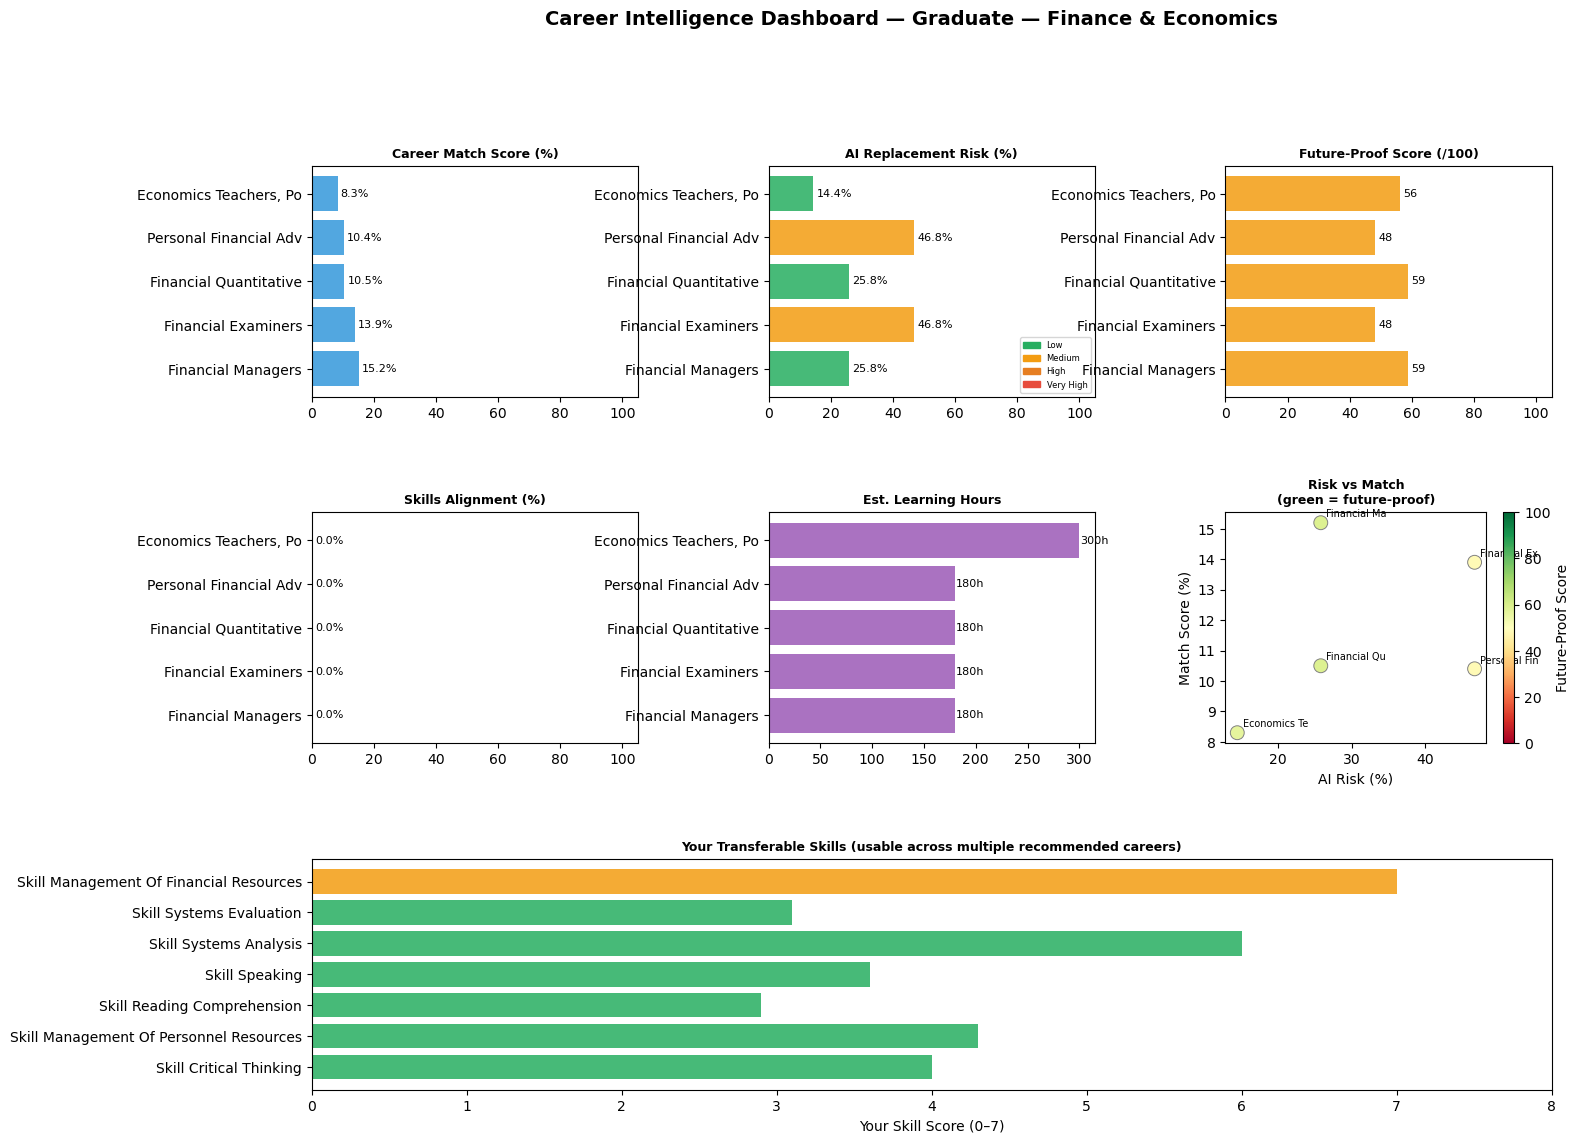

In [15]:
def plot_career_system_dashboard(system_output: dict, user_label: str = '', save_path: Path | None = None):
    """
    Full dashboard: career cards, risk vs demand, alignment scores, and learning path summary.
    """
    recs         = system_output['recommendations']
    details      = system_output['career_details']

    if recs.empty or not details:
        print('No results to plot.')
        return

    fig = plt.figure(figsize=(16, 12))
    gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.4)
    fig.suptitle(f'Career Intelligence Dashboard{" — " + user_label if user_label else ""}',
                 fontsize=14, fontweight='bold', y=1.01)

    careers  = [d['career_info']['career'][:22] for d in details]
    matches  = [d['career_info']['match_score'] for d in details]
    risks    = [d['risk_profile']['ai_risk_score'] for d in details]
    fp_score = [d['risk_profile']['future_proof_score'] for d in details]
    aligns   = [d['gap_report']['alignment_pct'] for d in details]
    lp_hrs   = [d['learning_path']['est_total_hours'] for d in details]
    risk_col = [d['risk_profile']['ai_risk_color'] for d in details]

    x = np.arange(len(careers))

    # Panel 1: Match Score
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.barh(careers, matches, color='#3498db', alpha=0.85)
    ax1.set_title('Career Match Score (%)', fontweight='bold', fontsize=9)
    ax1.set_xlim(0, 105)
    for i, v in enumerate(matches):
        ax1.text(v + 1, i, f'{v}%', va='center', fontsize=8)

    # Panel 2: AI Risk
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.barh(careers, risks, color=risk_col, alpha=0.85)
    ax2.set_title('AI Replacement Risk (%)', fontweight='bold', fontsize=9)
    ax2.set_xlim(0, 105)
    for i, v in enumerate(risks):
        ax2.text(v + 1, i, f'{v}%', va='center', fontsize=8)
    patches = [mpatches.Patch(color=v, label=k) for k, v in RISK_COLORS.items()]
    ax2.legend(handles=patches, fontsize=6, loc='lower right')

    # Panel 3: Future-Proof Score
    ax3 = fig.add_subplot(gs[0, 2])
    fp_colors = ['#27ae60' if f >= 60 else '#f39c12' if f >= 40 else '#e74c3c' for f in fp_score]
    ax3.barh(careers, fp_score, color=fp_colors, alpha=0.85)
    ax3.set_title('Future-Proof Score (/100)', fontweight='bold', fontsize=9)
    ax3.set_xlim(0, 105)
    for i, v in enumerate(fp_score):
        ax3.text(v + 1, i, f'{v:.0f}', va='center', fontsize=8)

    # Panel 4: Skills Alignment
    ax4 = fig.add_subplot(gs[1, 0])
    align_cols = ['#27ae60' if a >= 70 else '#f39c12' if a >= 50 else '#e74c3c' for a in aligns]
    ax4.barh(careers, aligns, color=align_cols, alpha=0.85)
    ax4.set_title('Skills Alignment (%)', fontweight='bold', fontsize=9)
    ax4.set_xlim(0, 105)
    for i, v in enumerate(aligns):
        ax4.text(v + 1, i, f'{v}%', va='center', fontsize=8)

    # Panel 5: Estimated Learning Hours
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.barh(careers, lp_hrs, color='#9b59b6', alpha=0.85)
    ax5.set_title('Est. Learning Hours', fontweight='bold', fontsize=9)
    for i, v in enumerate(lp_hrs):
        ax5.text(v + 1, i, f'{v:.0f}h', va='center', fontsize=8)

    # Panel 6: Risk vs Match scatter
    ax6 = fig.add_subplot(gs[1, 2])
    sc6 = ax6.scatter(risks, matches, c=fp_score, cmap='RdYlGn', s=100,
                       vmin=0, vmax=100, edgecolors='grey', linewidth=0.7)
    plt.colorbar(sc6, ax=ax6, label='Future-Proof Score')
    for i, c in enumerate(careers):
        ax6.annotate(c[:12], (risks[i], matches[i]), fontsize=7,
                     textcoords='offset points', xytext=(4, 4))
    ax6.set_xlabel('AI Risk (%)')
    ax6.set_ylabel('Match Score (%)')
    ax6.set_title('Risk vs Match\n(green = future-proof)', fontweight='bold', fontsize=9)

    # Panel 7: Transferable skills (span bottom row)
    ax7 = fig.add_subplot(gs[2, :])
    trans = system_output.get('transferable_skills', pd.DataFrame())
    if not trans.empty:
        t_colors = ['#27ae60' if v == 'High' else '#f39c12' for v in trans['Value'].head(8)]
        ax7.barh(trans['Skill'].head(8), trans['User Score'].head(8), color=t_colors, alpha=0.85)
        ax7.set_title('Your Transferable Skills (usable across multiple recommended careers)',
                      fontweight='bold', fontsize=9)
        ax7.set_xlabel('Your Skill Score (0–7)')
        ax7.set_xlim(0, 8)
    else:
        ax7.text(0.5, 0.5, 'Build more skills to unlock transferable skill analysis',
                 ha='center', va='center', transform=ax7.transAxes)
        ax7.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# Plot dashboard for graduate demo
plot_career_system_dashboard(result_grad, 'Graduate — Finance & Economics',
                              save_path=FIGURES_DIR / 'system_dashboard_graduate.png')

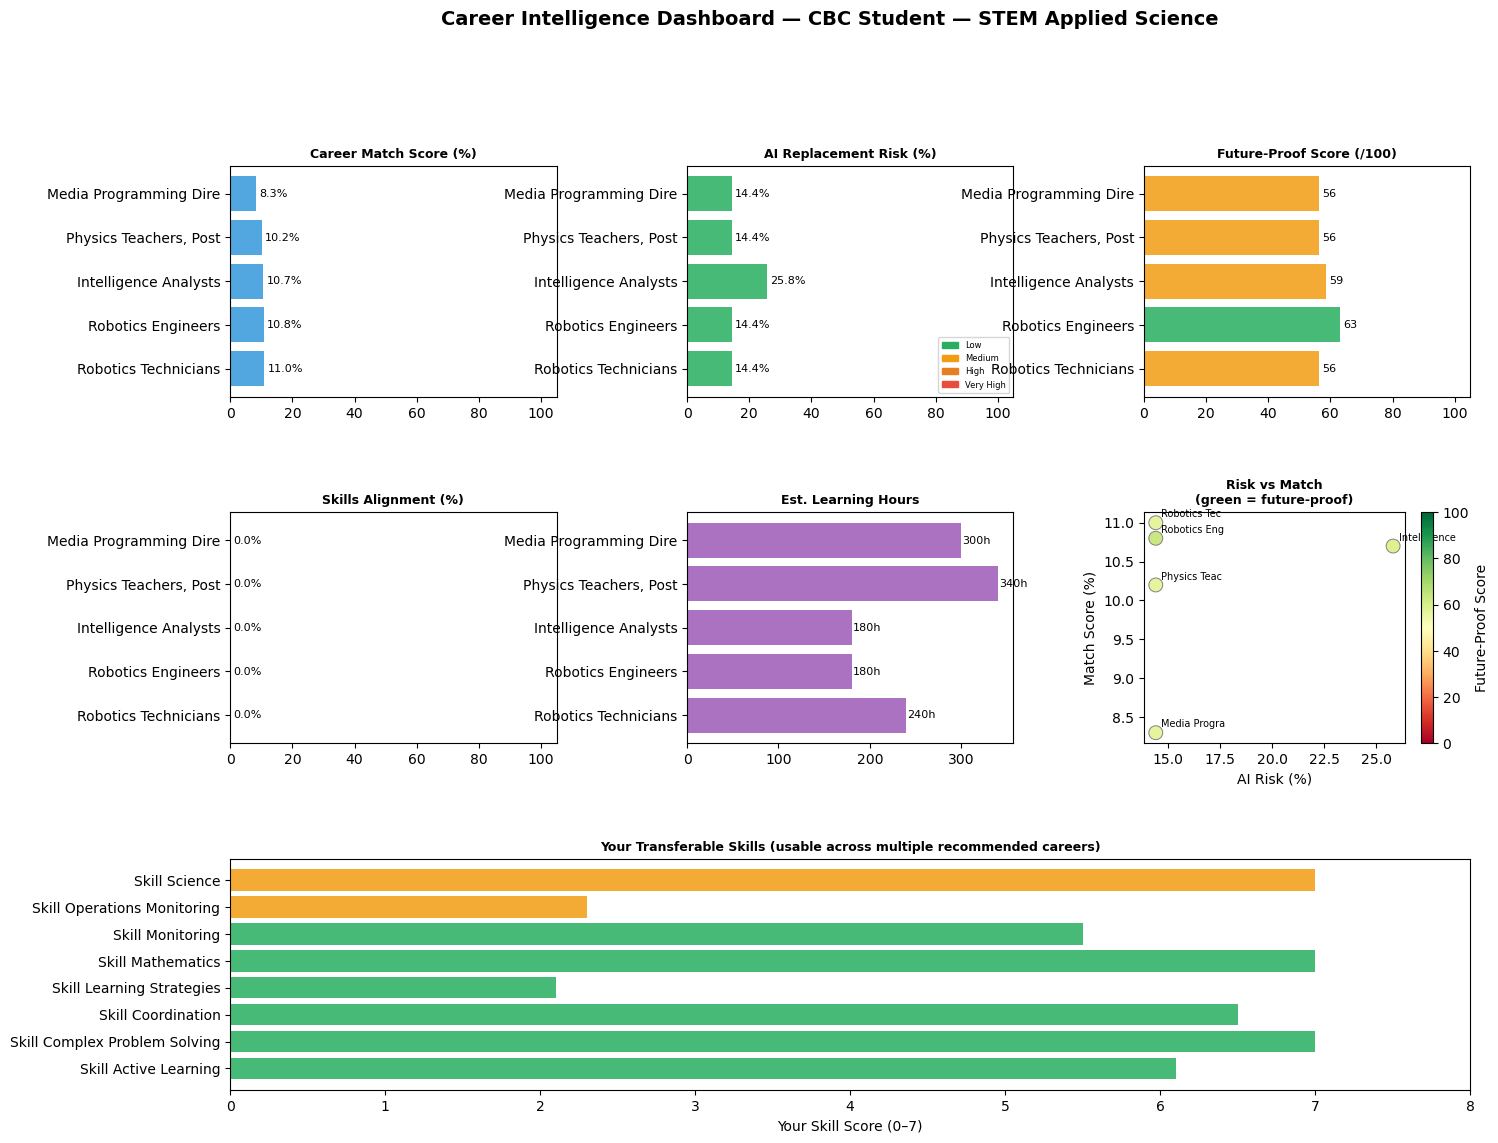

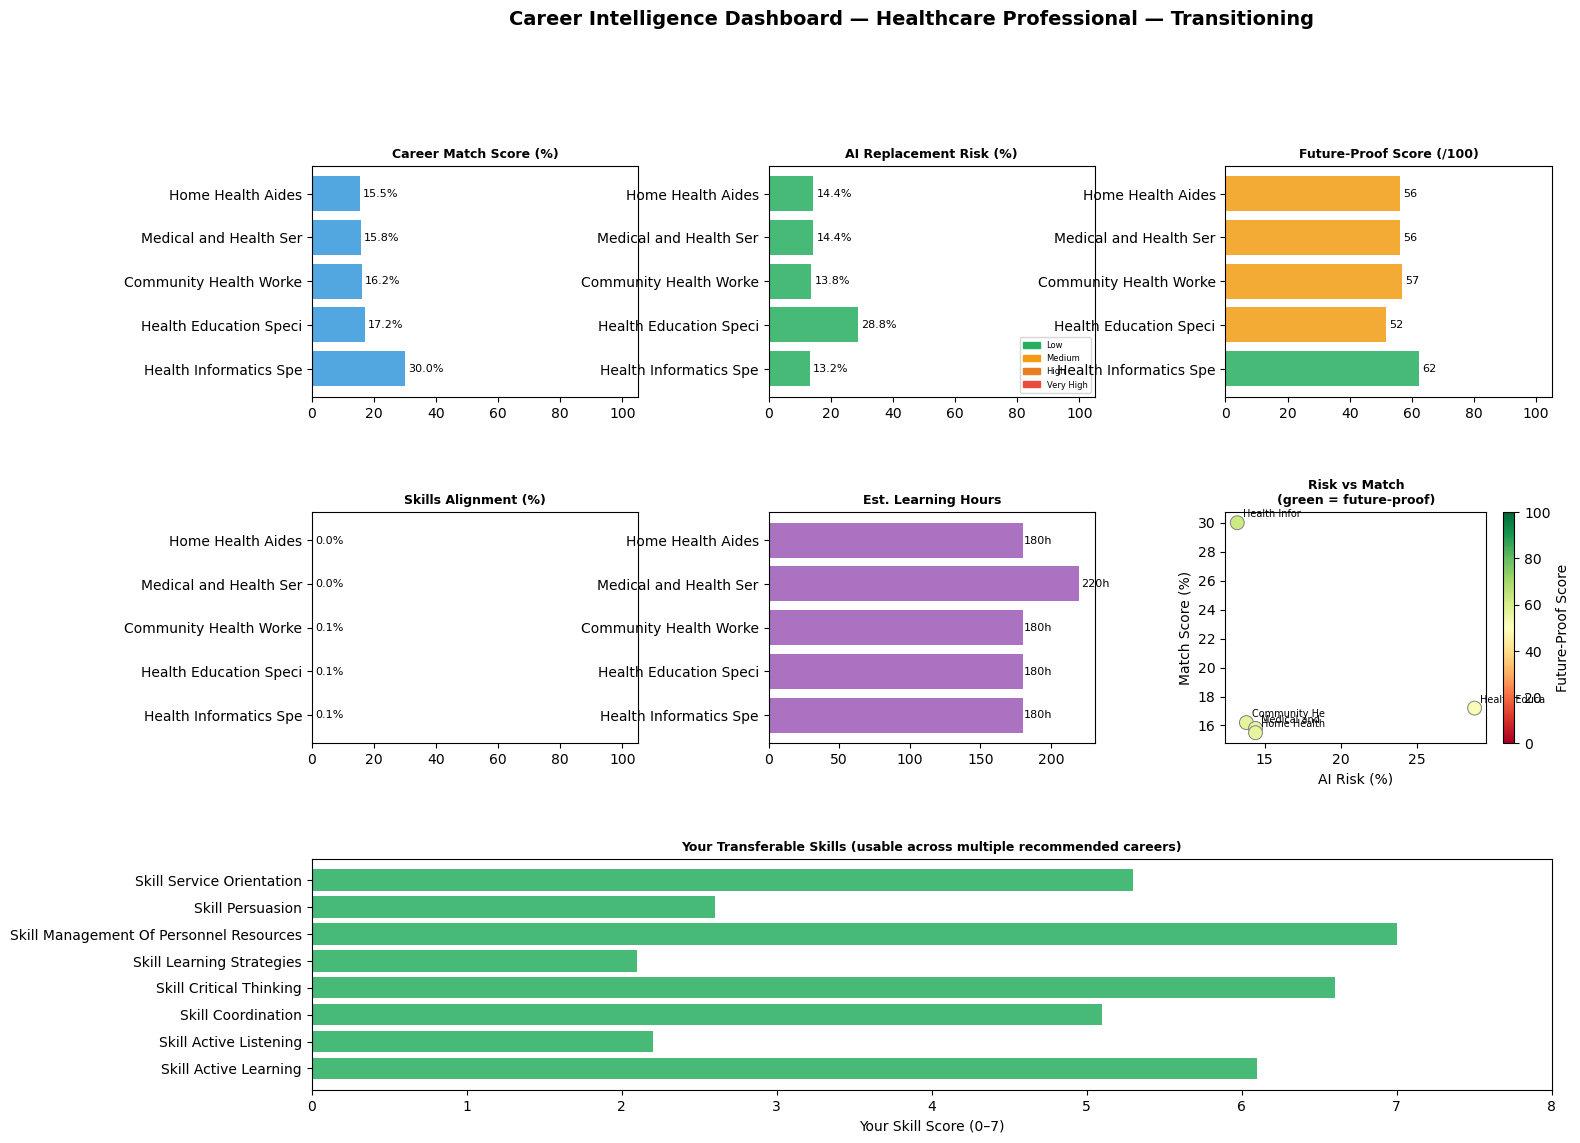

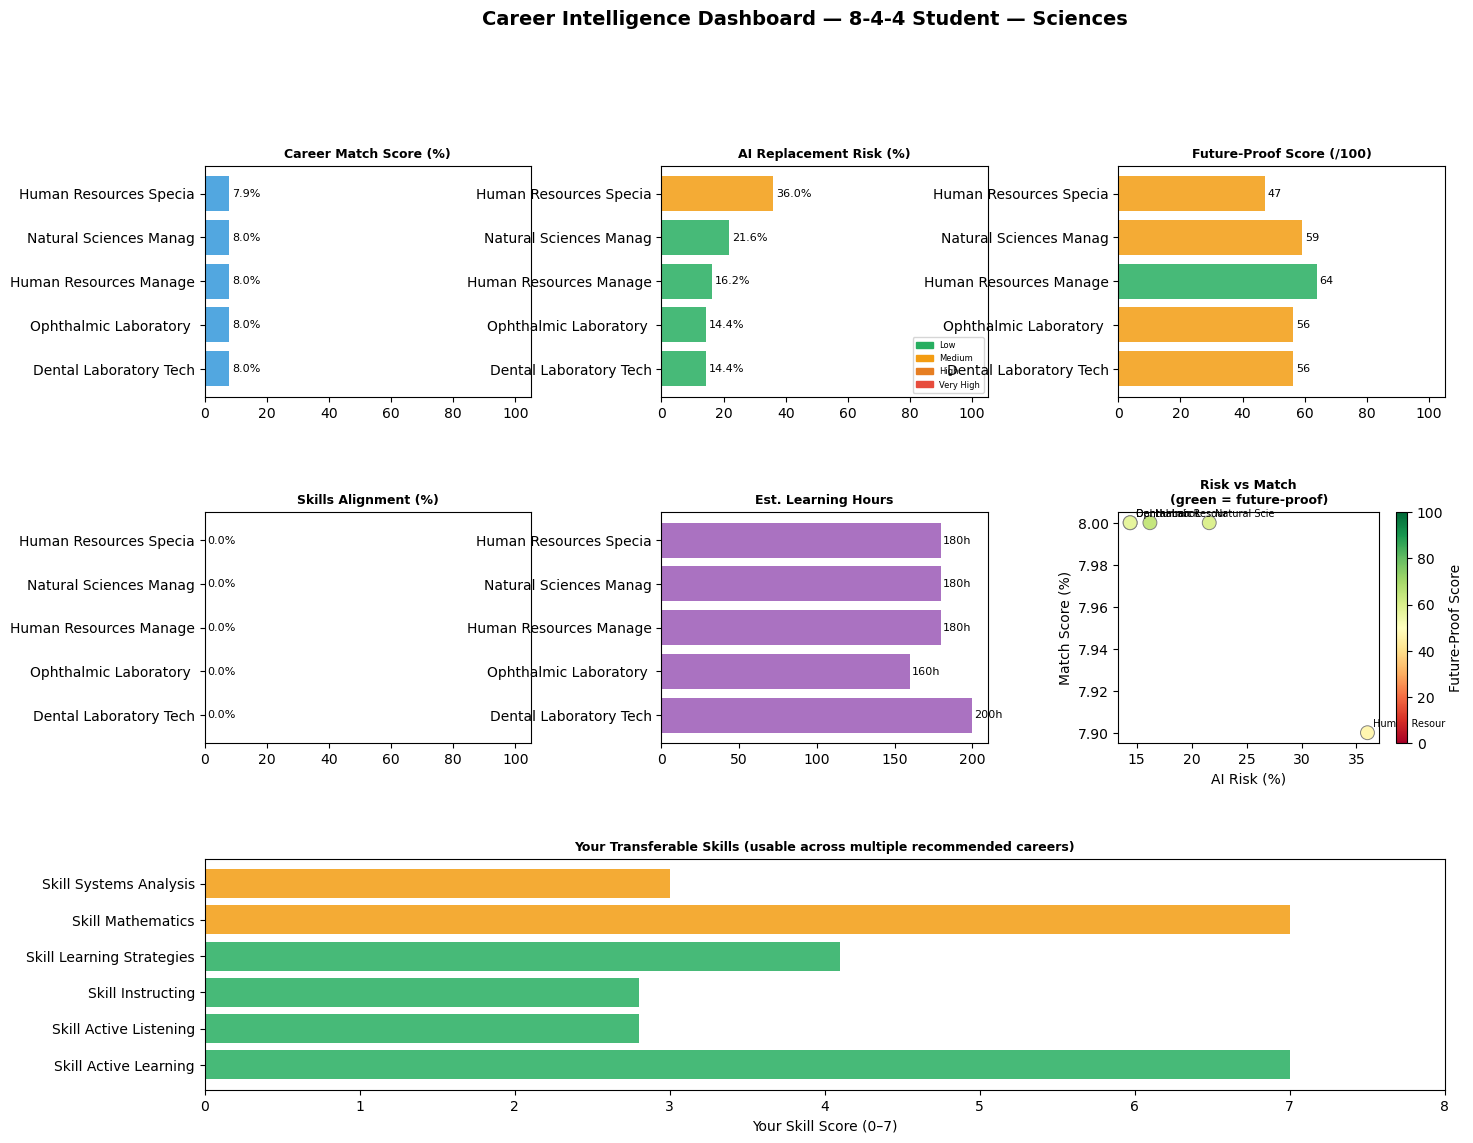

In [16]:
# Plot dashboards for other demos
plot_career_system_dashboard(result_cbc,  'CBC Student — STEM Applied Science',
                              save_path=FIGURES_DIR / 'system_dashboard_cbc.png')
plot_career_system_dashboard(result_prof, 'Healthcare Professional — Transitioning',
                              save_path=FIGURES_DIR / 'system_dashboard_professional.png')
plot_career_system_dashboard(result_844,  '8-4-4 Student — Sciences',
                              save_path=FIGURES_DIR / 'system_dashboard_844.png')

## 7.0 — Pipeline Performance Evaluation

In [17]:
# ── Latency benchmarks ────────────────────────────────────────────────────────
ALL_DEMOS = [
    ('CBC — STEM',        DEMO_CBC,  result_cbc),
    ('Graduate — Finance',DEMO_GRAD, result_grad),
    ('Professional',      DEMO_PROF, result_prof),
    ('8-4-4 — Sciences',  DEMO_844,  result_844),
]

print('=== Pipeline Performance Summary ===')
print()
summary_rows = []

for label, inp, out in ALL_DEMOS:
    m = out['pipeline_metrics']
    n_gaps = sum(len(d['gap_report']['all_gaps']) for d in out['career_details'])
    n_courses = sum(d['learning_path']['total_courses'] for d in out['career_details'])

    row = {
        'User Type'         : label,
        'Total Time (s)'    : m['total_seconds'],
        'Careers Analysed'  : m['n_careers_analysed'],
        'Total Gaps Found'  : n_gaps,
        'Courses Matched'   : n_courses,
        'Transferable Skills': m['n_transferable_skills'],
    }
    summary_rows.append(row)

perf_df = pd.DataFrame(summary_rows)
display(perf_df)

print(f"\nMean end-to-end latency : {perf_df['Total Time (s)'].mean():.2f}s")
print(f"Max latency             : {perf_df['Total Time (s)'].max():.2f}s")

=== Pipeline Performance Summary ===



,User Type,Total Time (s),Careers Analysed,Total Gaps Found,Courses Matched,Transferable Skills
0,CBC — STEM,1.713,5,40,62,8
1,Graduate — Finance,1.516,5,40,51,7
2,Professional,1.350,5,40,47,11
3,8-4-4 — Sciences,1.495,5,40,45,6



Mean end-to-end latency : 1.52s
Max latency             : 1.71s


## 8.0 — Save Full System & Integration Summary

In [18]:
# ── Serialise the full integrated system ──────────────────────────────────────
full_system = {
    'run_full_career_system'  : run_full_career_system,
    'parse_user_skills'       : parse_user_skills,
    'analyse_skills_gap'      : analyse_skills_gap,
    'generate_learning_path'  : generate_learning_path,
    'search_courses_for_skill': search_courses_for_skill,
    'categorise_risk'         : categorise_risk,
    'get_risk_explanation'    : get_risk_explanation,
    'get_mitigation_advice'   : get_mitigation_advice,
    'model_artifacts': {
        'retriever'           : retriever,
        'ranker'              : ranker,
        'scaler'              : scaler,
        'course_tfidf'        : COURSE_TFIDF,
        'course_matrix'       : COURSE_MATRIX,
    },
    'config': {
        'skill_cols'          : SKILL_COLS,
        'canonical_skills'    : CANONICAL_SKILLS,
        'skill_synonym_map'   : SKILL_SYNONYM_MAP,
        'risk_thresholds'     : RISK_THRESHOLDS,
        'risk_colors'         : RISK_COLORS,
        'risk_explanations'   : RISK_EXPLANATIONS,
        'education_course_levels': EDUCATION_COURSE_LEVELS,
        'user_type_job_zones' : USER_TYPE_JOB_ZONES,
        'career_goal_boosts'  : CAREER_GOAL_BOOSTS,
        'cbc_subject_skills'  : CBC_SUBJECT_SKILLS,
        'kcse_subject_skills' : KCSE_SUBJECT_SKILLS,
    }
}

joblib.dump(full_system, MODEL_DIR / 'career_system_v1.pkl')
print(f'Full system saved: {MODEL_DIR}/career_system_v1.pkl')

# ── Integration summary ───────────────────────────────────────────────────────
summary = {
    'notebook'            : '07 — Full System Integration',
    'system_version'      : '1.0',
    'pipeline_stages'     : [
        'Stage 1: Career Recommendation (Notebook 03)',
        'Stage 2: AI Risk Scoring (Notebook 05)',
        'Stage 3: Skills Gap Analysis (Notebook 04)',
        'Stage 4: Course Recommendation & Learning Path (Notebook 06)',
    ],
    'user_types_supported': ['cbc', '8-4-4', 'graduate', 'professional', 'postgraduate', 'diploma'],
    'occupations_covered' : int(len(master)),
    'courses_indexed'     : int(len(courses)),
    'skill_dimensions'    : int(len(SKILL_COLS)),
    'demos_run'           : len(ALL_DEMOS),
    'mean_latency_sec'    : round(float(perf_df['Total Time (s)'].mean()), 3),
    'system_outputs': [
        'Top-5 career recommendations with match score',
        'AI replacement risk per career (score + category + explanation)',
        'Future-proof score per career',
        'Skills gap analysis (critical / moderate / strong)',
        'Structured learning path (3 stages)',
        'Per-gap course recommendations (Coursera/edX/Udemy)',
        'Transferable skills summary',
        'Dashboard data (sector risk, demand charts)',
    ],
    'figures_generated'   : [str(p) for p in FIGURES_DIR.glob('*.png')],
}

with open(ARTIFACTS_DIR / '07_integration_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print()
print('='*60)
print('=== Kenya Career & Skills Intelligence System v1.0 ===')
print('=== ALL NOTEBOOKS COMPLETE                          ===')
print('='*60)
print()
for stage in summary['pipeline_stages']:
    print(f'   {stage}')
print()
print(f"  Occupations covered     : {summary['occupations_covered']}")
print(f"  Courses indexed         : {summary['courses_indexed']}")
print(f"  User types supported    : {len(summary['user_types_supported'])}")
print(f"  Mean latency            : {summary['mean_latency_sec']}s")
print(f"  System outputs          : {len(summary['system_outputs'])}")
print(f"  Dashboard figures       : {len(summary['figures_generated'])}")
print()
print('System is ready for deployment.')

Full system saved: models/career_system_v1.pkl

=== Kenya Career & Skills Intelligence System v1.0 ===
=== ALL NOTEBOOKS COMPLETE                          ===

   Stage 1: Career Recommendation (Notebook 03)
   Stage 2: AI Risk Scoring (Notebook 05)
   Stage 3: Skills Gap Analysis (Notebook 04)
   Stage 4: Course Recommendation & Learning Path (Notebook 06)

  Occupations covered     : 894
  Courses indexed         : 8050
  User types supported    : 6
  Mean latency            : 1.519s
  System outputs          : 8
  Dashboard figures       : 11

System is ready for deployment.
